# lightGBM - Running example of classify santander dataset

- Modified from: https://github.com/meanxai/machine_learning/blob/main/12.LGBM/6.santander.py
- A detailed description of this code can be found in [ttps://youtu.be/NqpkYja5g2Y](https://youtu.be/NqpkYja5g2Y)

In [1]:
import pandas as pd

# Read the Santander Customer Satisfaction Dataset.
# df.shape = (76020, 371)
df = pd.read_csv("data/santander.csv", encoding="latin-1")
print(df.head())

   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...

In [2]:
# Replace the values of the 'var3' feature containing -99999999
# with 2 and drop the 'ID' feature.
df["var3"] = df["var3"].replace(-999999, 2)
df.drop("ID", axis=1, inplace=True)


from sklearn.model_selection import train_test_split

# Separate features and label from the dataset
# and generate training and test data.
x_feat = df.drop("TARGET", axis=1)
y_target = df["TARGET"]
x_train, x_test, y_train, y_test = train_test_split(x_feat, y_target)

In [3]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

In [4]:
start_time = time.time()
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,  # η
    gamma=0.1,  # γ for pruning
    reg_lambda=1.0,  # λ for regularization
    base_score=0.5,  # initial prediction value
    subsample=0.5,  # Subsample ratio of the training instance
    colsample_bynode=0.5,  # Subsample ratio of columns for each split
    max_bin=int(1 / 0.03),  # sketch_eps is replaced by max_bin
    tree_method="approx",
)  # weighted quantile sketch

model.fit(x_train, y_train)

# Predict the test data and measure the performance with ROC-AUC.
y_prob = model.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print("\nXGBoost results:")
print("running time = {:.2f} seconds".format(time.time() - start_time))
print("ROC-AUC = {:.4f}".format(auc))


XGBoost results:
running time = 11.16 seconds
ROC-AUC = 0.8433


[LightGBM] [Info] Number of positive: 2254, number of negative: 54761
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14175
[LightGBM] [Info] Number of data points in the train set: 57015, number of used features: 252
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039533 -> initscore=-3.190272
[LightGBM] [Info] Start training from score -3.190272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

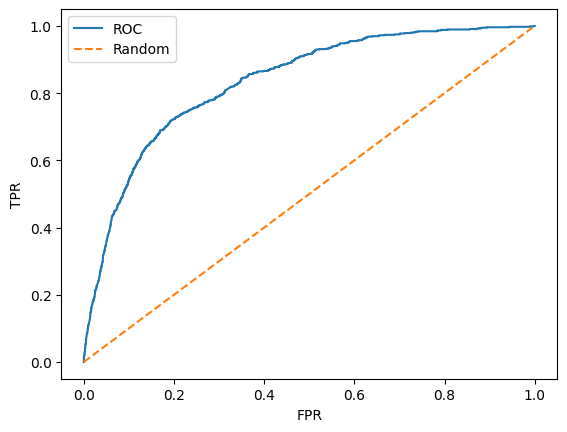

In [5]:
# 2. LightGBM
# Create a LightGBM model
start_time = time.time()
model = LGBMClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    data_sample_strategy="goss",  # default: gbdt - traditional gradient based decision tree
    top_rate=0.3,
    other_rate=0.2,
    enable_bundle=True,  # default: True. enable EFB
    is_unbalance=True,
)

# training
model.fit(x_train, y_train)

# Predict the test data and measure the performance with AUC.
y_pred = model.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print("\nLightGBM results:")
print("running time = {:.2f} seconds".format(time.time() - start_time))
print("ROC AUC = {0:.4f}".format(auc))

# Draw the ROC curve
fprs, tprs, thresholds = roc_curve(y_test, y_pred)

plt.plot(fprs, tprs, label="ROC")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
